In [13]:
from sqlalchemy import create_engine,Table, MetaData, Column, String, Date, Integer, Float, text

metadata = MetaData()
db_engine = create_engine("sqlite:///employees.db")

employees_table = Table(
    "employees", metadata,
    Column("id", Integer, primary_key=True, autoincrement=True),
    Column("first_name", String(50), nullable=False),
    Column("last_name", String(50), nullable=False),
    Column("email", String(100), unique=True, nullable=False),
    Column("phone_number", String(15)),
    Column("hire_date", Date, nullable=False),
    Column("job_title", String(50), nullable=False),
    Column("salary", Float, nullable=False),
    Column("department_id", Integer)
)
# Drop the table if it exists
employees_table.drop(db_engine, checkfirst=True)
metadata.create_all(db_engine)

In [7]:
from datetime import datetime
from sqlalchemy import insert
from random import randint
# Dummy data
employees = [
    ['John', 'Doe', 'john.doe@example.com', '123-456-7890', datetime(2021, 5, 1), 'Software Engineer', 70000, 2],
    ['Jane', 'Smith', 'jane.smith@example.com', '234-567-8901', datetime(2020, 8, 15), 'HR Manager', 80000, 1],
    ['Jim', 'Beam', 'jim.beam@example.com', '345-678-9012', datetime(2019, 11, 3), 'Sales Representative', 50000, 3],
    ['Jessica', 'Jones', 'jessica.jones@example.com', '456-789-0123', datetime(2018, 4, 23), 'Marketing Specialist', 60000, 4],
    ['Michael', 'Brown', 'michael.brown@example.com', '567-890-1234', datetime(2022, 1, 9), 'DevOps Engineer', 75000, 2],
    ['Emily', 'Davis', 'emily.davis@example.com', '678-901-2345', datetime(2021, 3, 11), 'Product Manager', 85000, 4],
    ['Daniel', 'Wilson', 'daniel.wilson@example.com', '789-012-3456', datetime(2020, 10, 30), 'Data Scientist', 95000, 2],
    ['Sophia', 'Taylor', 'sophia.taylor@example.com', '890-123-4567', datetime(2021, 6, 7), 'Recruiter', 55000, 1],
    ['Lucas', 'Martinez', 'lucas.martinez@example.com', '901-234-5678', datetime(2019, 2, 18), 'Sales Manager', 70000, 3],
    ['Olivia', 'Garcia', 'olivia.garcia@example.com', '012-345-6789', datetime(2023, 7, 20), 'Junior Developer', 50000, 2]
]

In [19]:
with db_engine.begin() as connection:
    for emp in employees:
        query = insert(employees_table).values(
            id=randint(10000, 99999),
            first_name=emp[0],
            last_name=emp[1],
            email=emp[2],
            phone_number=emp[3],
            hire_date=emp[4],
            job_title=emp[5],
            salary=emp[6],
            department_id=emp[7]
        )
        connection.execute(query)
print("Data inserted Successfully")

Data inserted Successfully


In [ ]:
from getpass import getpass
import os

os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass("Input hugging face API Token")
os.environ['COHERE_API_KEY'] = getpass("Input Cohere API Token")

In [14]:
from langchain_experimental.sql import SQLDatabaseChain
from langgraph.graph import MessagesState
from langchain_community.utilities import SQLDatabase
from langchain_community.llms.cohere import Cohere
from langchain_ollama import ChatOllama

# Forcefully made return_sql=True, return_direct=True to get the generated SQL
# else, it will create and execute query internally which is sometime error prone
def generate_query(state: MessagesState):
    llm_ollama = ChatOllama(model = "granite3.1-dense:2b", max_tokens=100, temperature=0)
    sql_chain = SQLDatabaseChain.from_llm(llm_ollama, db=SQLDatabase(db_engine),  return_sql=True, return_direct=True)
    messages = state['messages']
    response = sql_chain.invoke(messages)
    return {"messages": [response['result']]}

# Query cleanup can be done using another LLM with a proper prompt but, 
# in this case I am doing simple string manupulation as the model's output is 
# almost correct
def clean_query(state: MessagesState):
    messages = state['messages'][-1]
    corrected_query = messages.content.replace("`","").replace("sql","")
    return {"messages": [corrected_query]}

# Execute the generated query and extract or formmat output as per requirement
def execute_query(state: MessagesState):
    messages = state['messages'][-1]
    sql = messages.content
    with db_engine.begin() as connection:
        answer = connection.execute(text(sql)).fetchall()
    return {"messages": [str(answer)]}

In [15]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(MessagesState)

workflow.add_node("Query_Generator", generate_query)
workflow.add_node("Query_Cleaner", clean_query)
workflow.add_node("Query_Executor", execute_query)

workflow.add_edge(START, "Query_Generator")
workflow.add_edge("Query_Generator", "Query_Cleaner")
workflow.add_edge("Query_Cleaner", "Query_Executor")
workflow.add_edge("Query_Executor", END)

graph = workflow.compile()

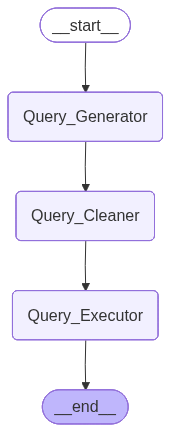

In [16]:
graph

In [21]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "What is the highest salary of all employees? Answer should be in single word or number"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Query_Generator':
---
{'messages': ['SELECT MAX(salary) FROM employees;']}

---

Output from node 'Query_Cleaner':
---
{'messages': ['SELECT MAX(salary) FROM employees;']}

---

Output from node 'Query_Executor':
---
{'messages': ['[(95000.0,)]']}

---



In [20]:
from sqlalchemy import text

with db_engine.begin() as connection:
    # Print a few rows
    rows = connection.execute(
        text("SELECT * FROM employees LIMIT 10;")
    ).fetchall()
    for row in rows:
        print(row)


(20435, 'Olivia', 'Garcia', 'olivia.garcia@example.com', '012-345-6789', '2023-07-20', 'Junior Developer', 50000.0, 2)
(30004, 'Lucas', 'Martinez', 'lucas.martinez@example.com', '901-234-5678', '2019-02-18', 'Sales Manager', 70000.0, 3)
(37004, 'Sophia', 'Taylor', 'sophia.taylor@example.com', '890-123-4567', '2021-06-07', 'Recruiter', 55000.0, 1)
(40055, 'John', 'Doe', 'john.doe@example.com', '123-456-7890', '2021-05-01', 'Software Engineer', 70000.0, 2)
(42153, 'Jane', 'Smith', 'jane.smith@example.com', '234-567-8901', '2020-08-15', 'HR Manager', 80000.0, 1)
(62600, 'Daniel', 'Wilson', 'daniel.wilson@example.com', '789-012-3456', '2020-10-30', 'Data Scientist', 95000.0, 2)
(65424, 'Emily', 'Davis', 'emily.davis@example.com', '678-901-2345', '2021-03-11', 'Product Manager', 85000.0, 4)
(73373, 'Jim', 'Beam', 'jim.beam@example.com', '345-678-9012', '2019-11-03', 'Sales Representative', 50000.0, 3)
(78484, 'Jessica', 'Jones', 'jessica.jones@example.com', '456-789-0123', '2018-04-23', 'Ma